<a href="https://colab.research.google.com/github/rebecca-yoo/github-slideshow/blob/main/Project_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 5

1. Fit a pytorch model to the oasis data that treats gold lesions as the outcome and T2 value as the predictor. Use a bias term, sigmoid output activation function and no hidden layers. Do not split the data into a testing and training dataset. Demonstrate that the fitted values are the same as those obtained with logistic regression.  

2. Fit a pytorch neural network with two hidden layers on the diamond dataset from the previous project predicting price. Evaluate your predictions on held out test set data.

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.687421
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  100
Model:                          Logit   Df Residuals:                       98
Method:                           MLE   Df Model:                            1
Date:                Mon, 04 Oct 2021   Pseudo R-squ.:                0.008262
Time:                        20:51:44   Log-Likelihood:                -68.742
converged:                       True   LL-Null:                       -69.315
Covariance Type:            nonrobust   LLR p-value:                    0.2845
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0005      0.201      0.002      0.998      -0.394       0.395
x              0.2159      0.

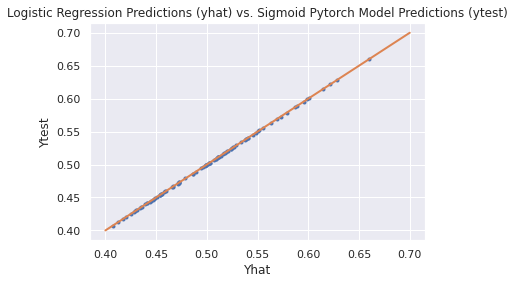

In [2]:
import pandas as pd
import torch
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
## this sets some style parameters
sns.set()

## Download in the data if it's not already there
! if [ ! -e oasis.csv ]; \
  then wget https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv; \
fi;

dat = pd.read_csv('https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv')

## Create a normalized regression variable
dat = dat.assign(y = dat.GOLD_Lesions)
dat = dat.assign(x = (dat.T2 - np.mean(dat.T2)) / np.std(dat.T2))

fit = smf.logit('y~x', data=dat).fit()
print(fit.summary())

# The in sample predictions
yhat = 1 / (1 + np.exp(-fit.fittedvalues))

n = dat.shape[0]

## Get the y and x from 
xtraining = torch.from_numpy(dat['x'].values)
ytraining = torch.from_numpy(dat['y'].values)

## PT wants floats
xtraining = xtraining.float()
ytraining = ytraining.float()

## Dimension is 1xn not nx1
## squeeze the second dimension
xtraining = xtraining.unsqueeze(1)
ytraining = ytraining.unsqueeze(1)

## Show that everything is the right size
print([xtraining.shape, 
 ytraining.shape,
 [n, 1]
 ])

class LogisticRegression(torch.nn.Module):
     def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias = True)
     def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

## Then the model is simply  
model = LogisticRegression()

## MSE is the loss function
loss_fn = torch.nn.BCELoss()  

## Set the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

## Loop over iterations
for t in range(10000):

  ## Forward propagation
  y_pred = model(xtraining)

  ## the loss for this interation
  loss = loss_fn(y_pred, ytraining)

  ## Zero out the gradients before adding them up 
  optimizer.zero_grad()
  
  ## Backprop
  loss.backward()
  
  ## Optimization step
  optimizer.step()

ytest = model(xtraining)
ytest = ytest.detach().numpy().reshape(-1)
plt.plot(yhat, ytest, '.')
plt.plot([0.4, 0.7], [0.4, 0.7], linewidth=2)
plt.title('Logistic Regression Predictions (yhat) vs. Sigmoid Pytorch Model Predictions (ytest)')
plt.xlabel('Yhat')
plt.ylabel('Ytest')
for param in model.parameters():  
  print(param.data)


[torch.Size([40519, 18]), torch.Size([40519, 1]), torch.Size([13421, 18]), torch.Size([13421, 1])]


TypeError: ignored

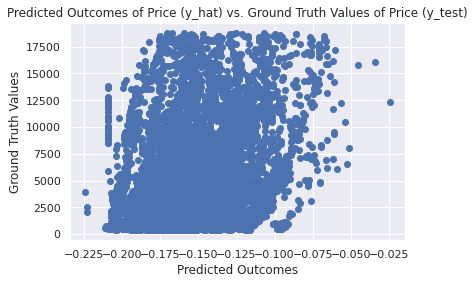

In [4]:
N, H1, H2 = 53940, 18, 18

df = pd.read_csv('https://raw.githubusercontent.com/tidyverse/ggplot2/master/data-raw/diamonds.csv')

# transform data

df = pd.get_dummies(df, columns=["cut"], prefix="Cut", drop_first = True)
df = pd.get_dummies(df, columns=["color"], prefix="Color", drop_first = True)
df = pd.get_dummies(df, columns=["clarity"], prefix="Clarity", drop_first = True)

y_1 = df['price']
x_1 = df.drop(['depth', 'table', 'price', 'x', 'y', 'z'], axis = 1)

y_1 = torch.from_numpy(y_1.values)
x_1 = torch.from_numpy(x_1.values)

trainFraction = 0.75

## Hold out data
sample = np.random.uniform(size = 53940) < trainFraction
xtrain_1 = x_1[sample]
ytrain_1 = y_1[sample]
xtest_1 =  x_1[~sample]
ytest_1 =  y_1[~sample]

## PT wants floats
xtrain_1 = xtrain_1.float()
ytrain_1 = ytrain_1.float()
ytrain_1_val = ytrain_1
xtest_1 = xtest_1.float()
ytest_1 = ytest_1.float()

## Dimension is 1xn not nx1
## squeeze the second dimension
ytrain_1 = ytrain_1.unsqueeze(1)
ytest_1 = ytest_1.unsqueeze(1)

print([
 xtrain_1.shape,
 ytrain_1.shape,
 xtest_1.shape,
 ytest_1.shape,
])

## Define the model
## Dimension of the hidden layer

## Number of predictors
D_in = xtrain_1.shape[1]
D_out = 1
model_1 = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.ReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.ReLU(),
    torch.nn.Linear(H2, D_out)
)

loss_fn_1 = torch.nn.MSELoss(reduction='mean')

optimizer_1 = torch.optim.Adam(model.parameters(), lr=1e-5)

for j in range(500):
  for k in range(xtrain_1.shape[0]//128):
    ytrain_pred_1 = model_1(xtrain_1[k*128:k*128+128])
    loss_1 = loss_fn_1(ytrain_pred_1, ytrain_1[k*128:k*128+128])
    #if j % 100 == 99:
      # print(j, loss.item())
    optimizer_1.zero_grad()
    loss_1.backward()
    optimizer_1.step()

## try prediction
ytesting_pred_1 = model_1(xtest_1)
a = ytesting_pred_1.detach().numpy().reshape(-1)

plt.scatter(a, ytest_1)
plt.title('Predicted Outcomes of Price (y_hat) vs. Ground Truth Values of Price (y_test)')
plt.xlabel('Predicted Outcomes')
plt.ylabel('Ground Truth Values')

mse = np.sqrt(np.mean((ytrain_1_val-ytrain_pred_1)**2))
print('The RMSE is ' + str(mse))